In [1]:
import matplotlib.pyplot as plt
import monolayer_tracking.utils as mt_utils
import numpy as np
import pandas as pd

from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator

plt.style.use('dark_background')

# write STG from bounding box

In [13]:
input=r"Y:\raw_data\Mosaic\20240708 FUCCI halo ME comparison\adhered\tilebounds.STG"
output=None
use_colonies='all'
x_spacing=145
y_spacing=205
padding=np.array([335,500])

verbose=True

(111471.1, 121170.9, 41104.65, 47096.35)

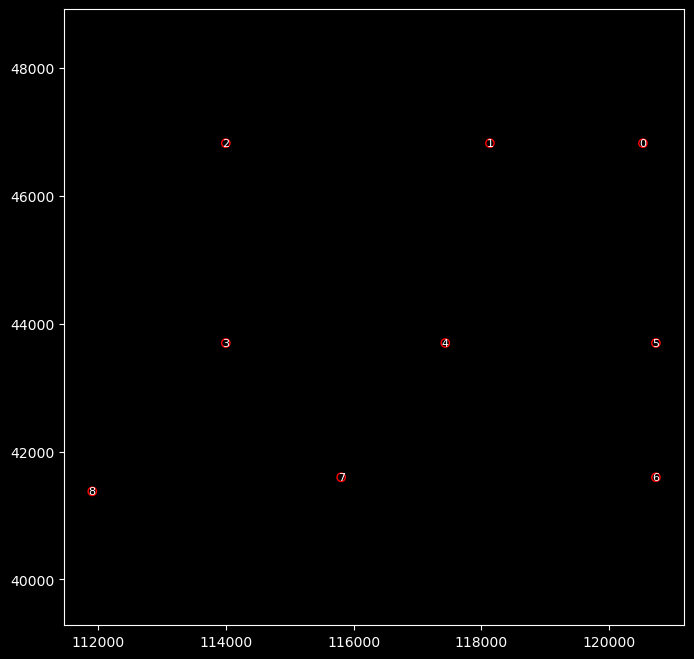

In [14]:
if not output:
    output=input.replace('.STG', '_tiled.STG')

plt.figure(figsize=(8,8))
head, points=mt_utils.read_STG(input)
plt.scatter(points['x'], points['y'], fc='none', ec='r')
for i, txt in enumerate(points.index):
    plt.annotate(txt, (points['x'][i], points['y'][i]), fontsize=8, color='white', ha='center', va='center')

plt.axis('equal')

In [15]:
colony_points=1
num_colonies=len(points)//colony_points
if num_colonies*colony_points<len(points):
    print(f'Warning: {len(points)} points is not a multiple of {colony_points}. Dropping {len(points)%colony_points} points.')
slide_regions=np.array_split(points, num_colonies)

boundary_points=[0,0]#[1,-2]
tiled=[]
for n, slide_bounds in enumerate(slide_regions):
    xmin, xmax=slide_bounds['x'].sort_values().iloc[boundary_points]
    ymin, ymax=slide_bounds['y'].sort_values().iloc[boundary_points]

    max_corner=pd.Series({'x': xmax, 'y': ymax})
    min_corner=pd.Series({'x': xmin, 'y': ymin})

    z_position=slide_bounds['current_z'].mean()

    tile_centers=mt_utils.grid_from_bbox(min_corner, max_corner, x_spacing, y_spacing, padding, reorder=False)

    # Assign z positions, etc. to each stage position via interpolation
    if len(slide_bounds)==1:
        interpolator=NearestNDInterpolator(slide_bounds[['x', 'y']], slide_bounds[['current_z','AF_offset']])
    else:
        interpolator=LinearNDInterpolator(slide_bounds[['x', 'y']], slide_bounds[['current_z','AF_offset']])
        
    z, AF=interpolator(tile_centers[['x', 'y']]).T
    tile_centers['current_z']=np.round(z,2)
    tile_centers['starting_z']=tile_centers['current_z']
    tile_centers['AF_offset']=AF.astype(int)
    tile_centers['position']=f'Region{n+1}'
    tile_centers['stage_number']=[f'_{i}' for i in range(1, len(tile_centers)+1)]
    tile_centers[['FALSE','-9999', 'TRUE_1', 'TRUE_2', '0', '-1', 'endline']]=np.array(slide_bounds[['FALSE', '-9999', 'TRUE_1', 'TRUE_2', '0', '-1', 'endline']])[0]
    tiled.append(tile_centers)
    
tiled=pd.concat(tiled)
tiled=tiled.iloc[::-1] # reverse order: right and down

c:\Users\Andy\anaconda3\envs\cellpose\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


144 total stage positions


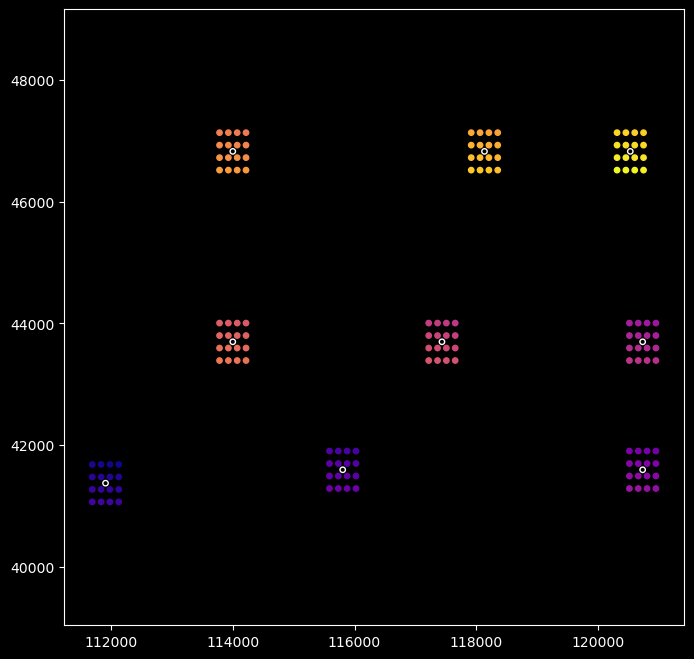

In [16]:
plt.figure(figsize=(8,8))
plt.scatter(tiled['x'], tiled['y'], c=range(len(tiled)), cmap='plasma', s=15)
#for i, txt in enumerate(tiled.index):
#    plt.annotate(txt, (tiled['x'][i], tiled['y'][i]))
plt.scatter(points['x'], points['y'], ec='white', fc='none', s=15)
plt.axis('equal')
print(f'{len(tiled)} total stage positions')

In [ ]:
tiled['position']=tiled['position']+tiled['stage_number'] # unique name for each stage position
tiled=tiled[points.columns] # reorder columns for exporting tiled
head[-1]=f'{len(tiled)}\n'
mt_utils.write_STG(output, head, tiled)